In [7]:
import pandas as pd
from google.colab import drive
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import os
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
from mlxtend.preprocessing import TransactionEncoder

In [8]:
file_path = "https://drive.google.com/uc?id=1eJ8zjnXbRZzAkWpYXvfxkMxgSFQIyx0f"
df = pd.read_csv(file_path)

In [9]:
#Data Cleaning
df = df.dropna(subset=['product_code'])
df = df[df['quantity'] > 0]
df['order_id'] = df['order_id'].astype(str)
df['product_code'] = df['product_code'].astype(str)

In [10]:
#Filter produk populer agar basket tidak terlalu besar
product_counts = df['product_code'].value_counts()
top_products = product_counts[product_counts > 100].index  # produk dengan transaksi >100
df = df[df['product_code'].isin(top_products)]

In [11]:
#Ubah dataset ke bentuk transaksi (list of list)
transactions = df.groupby('order_id')['product_code'].apply(list).tolist()

In [12]:
#Encode transaksi ke format one-hot
te = TransactionEncoder()
te_matrix = te.fit(transactions).transform(transactions, sparse=True)  # gunakan sparse untuk hemat RAM
basket = pd.DataFrame.sparse.from_spmatrix(te_matrix, columns=te.columns_)

print("Ukuran basket:", basket.shape)

Ukuran basket: (18092, 1267)


In [13]:
#Apriori Algorithm (gunakan threshold kecil dulu)
frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True, verbose=1, low_memory=True)
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)

print("\nFrequent Itemsets (Top 10):")
print(frequent_itemsets.head(10))

Processing 246 combinations | Sampling itemset size 5

Frequent Itemsets (Top 10):
       support  itemsets
1237  0.164880  (85123A)
705   0.105682   (22423)
1233  0.097502  (85099B)
165   0.085120   (21212)
174   0.078654   (21232)
50    0.074784   (20725)
1174  0.070473   (84879)
341   0.067931   (21754)
1198  0.064172   (84991)
742   0.062901   (22470)


In [14]:
#Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by=['lift', 'confidence'], ascending=False)

print("\nAssociation Rules (Top 10):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Association Rules (Top 10):
                 antecedents            consequents  support  confidence  \
32763         (22524, 22523)         (22525, 22522)  0.00503    0.900990   
32758         (22525, 22522)         (22524, 22523)  0.00503    0.883495   
30888  (22521, 22524, 22523)         (22525, 22520)  0.00514    0.948980   
30893         (22525, 22520)  (22521, 22524, 22523)  0.00514    0.794872   
34479  (22521, 22522, 22524)         (22525, 22520)  0.00503    0.947917   
34482         (22525, 22520)  (22521, 22522, 22524)  0.00503    0.777778   
30895         (22524, 22523)  (22521, 22525, 22520)  0.00514    0.920792   
30886  (22521, 22525, 22520)         (22524, 22523)  0.00514    0.808696   
30897         (22521, 22524)  (22525, 22523, 22520)  0.00514    0.794872   
30884  (22525, 22523, 22520)         (22521, 22524)  0.00514    0.930000   

             lift  
32763  158.259348  
32758  158.259348  
30888  146.743066  
30893  146.743066  
34479  146.578704  
34482  146.578

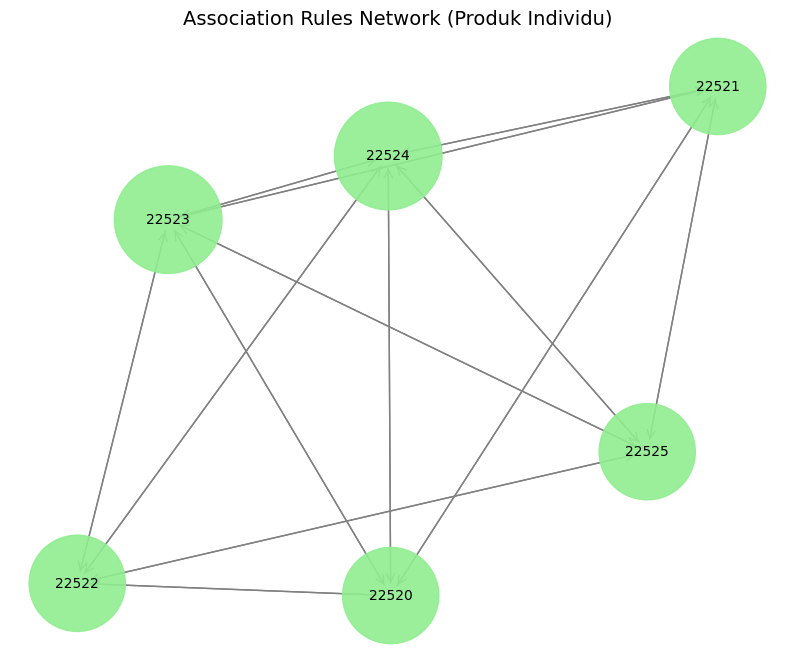

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Data rules (disalin dari hasil sebelumnya)
data = {
    "antecedents": [
        (22524, 22523),
        (22525, 22522),
        (22521, 22524, 22523),
        (22525, 22520),
        (22521, 22522, 22524),
        (22525, 22520),
        (22524, 22523),
        (22521, 22525, 22520),
        (22521, 22524),
        (22525, 22523, 22520)
    ],
    "consequents": [
        (22525, 22522),
        (22524, 22523),
        (22525, 22520),
        (22521, 22524, 22523),
        (22525, 22520),
        (22521, 22522, 22524),
        (22521, 22525, 22520),
        (22524, 22523),
        (22525, 22523, 22520),
        (22521, 22524)
    ],
    "support": [0.00503,0.00503,0.00514,0.00514,0.00503,0.00503,0.00514,0.00514,0.00514,0.00514],
    "confidence": [0.9009,0.8835,0.9489,0.7948,0.9479,0.7777,0.9207,0.8086,0.7948,0.9300],
    "lift": [158.25,158.25,146.74,146.74,146.57,146.57,144.86,144.86,143.80,143.80]
}

rules_df = pd.DataFrame(data)

# Buat graph baru
G = nx.DiGraph()

# Tambahkan edge antar produk individu
for _, row in rules_df.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'], confidence=row['confidence'])

# Hitung centrality untuk ukuran node
centrality = nx.degree_centrality(G)

# Visualisasi
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Gambar node dengan ukuran proporsional terhadap centrality
nx.draw_networkx_nodes(G, pos,
                       node_size=[v*3000 for v in centrality.values()],
                       node_color='lightgreen', alpha=0.9)

# Gambar edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color="gray")

# Label produk
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Association Rules Network (Produk Individu)", fontsize=14)
plt.axis("off")
plt.show()
